In [1]:
%reset
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
import os
from catboost import CatBoostClassifier
import catboost as cb
from sklearn.model_selection import learning_curve


In [2]:
def convert_sample(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image,[32,32]).numpy()
    image = image.reshape(1,-1)
    return image


file_dir = os.path.realpath(os.path.dirname('__file__'))

In [3]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = file_dir,
                        download=False,
                        shuffle_files=True,
                        as_supervised=True,
                        batch_size=-1)

In [4]:
train_dataset       = tfds.as_numpy(ds1)
train_dataset_image = np.vstack(list(map(convert_sample,train_dataset[0])))
train_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(train_dataset_image)
train_dataset_label = train_dataset[1].reshape(-1,)    
print(f'Shape of training data features (observations,features): {train_dataset_image_Scaled.shape}')
print(f'Shape of training data labels (observations,): {train_dataset_label.shape}')

validation_dataset  = tfds.as_numpy(ds3)
validation_dataset_image = np.vstack(list(map(convert_sample,validation_dataset[0])))
validation_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(validation_dataset_image)
validation_dataset_label = validation_dataset[1].reshape(-1,) 
   
test_dataset       = tfds.as_numpy(ds2)
test_dataset_image = np.vstack(list(map(convert_sample,test_dataset[0])))
test_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(test_dataset_image)
test_dataset_label = test_dataset[1].reshape(-1,)

Shape of training data features (observations,features): (52429, 1024)
Shape of training data labels (observations,): (52429,)


In [ ]:
baseline model
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_dataset_image_Scaled, train_dataset_label)

# baseline accuracy = 70%
y_test_hat = rf.predict(validation_dataset_image_Scaled)
accuracy = accuracy_score(validation_dataset_label, y_test_hat)
print(f'Baseline model accuracy: {round(accuracy * 100, 1)}% accuracy.')

# Finding feature importance
importance = rf.feature_importances_
feature_pd = pd.Series(importance)
feature_importance = feature_pd.sort_values(ascending=False).reset_index()
print(feature_importance[:20])

# vægtningen af alle variabler giver tilsammen 1. De 20 vigtigste giver 0.31
print(sum((feature_importance[0][:10])))

rf.score(validation_dataset_image_Scaled, validation_dataset_label)



In [ ]:
#plot Random Forest learning curve with 32*32 images and grayscale

rf_train_sizes, rf_train_scores, rf_valid_scores = learning_curve(RandomForestClassifier(), 
                                                        train_dataset_image_Scaled, 
                                                        train_dataset_label, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, 
                                                        random_state=42)
                

#Training set size = 4194, 8388, 12582, 16776, 20970, 25164, 29358, 33552, 37746, 41940
# Using all default values for the RandomForestClassifier class leads to overfitting. As stated in scikit-learn documentation,
# The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) 
# lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(rf_train_sizes, np.mean(rf_train_scores, axis=1), label='Training score')
plt.plot(rf_train_sizes, np.mean(rf_valid_scores, axis=1), label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('Random forest classifier Learning Curve')
plt.legend()
plt.show()

In [11]:
#Taking random forest model and holding it up against the test set
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_dataset_image_Scaled, train_dataset_label)
y_test_hat = rf.predict(test_dataset_image_Scaled)
accuracy = accuracy_score(test_dataset_label, y_test_hat)
print(f'Baseline model accuracy: {round(accuracy * 100, 1)}% accuracy.')

#Random forest model accuracy: 72.5% accuracy.

Baseline model accuracy: 72.5% accuracy.


0.7252747252747253

In [7]:
#SVM Model on the training data
SVM_train_sizes, SVM_train_scores, SVM_valid_scores = learning_curve(svm.LinearSVC(),
                                                        train_dataset_image_Scaled,
                                                        train_dataset_label,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        random_state=42)


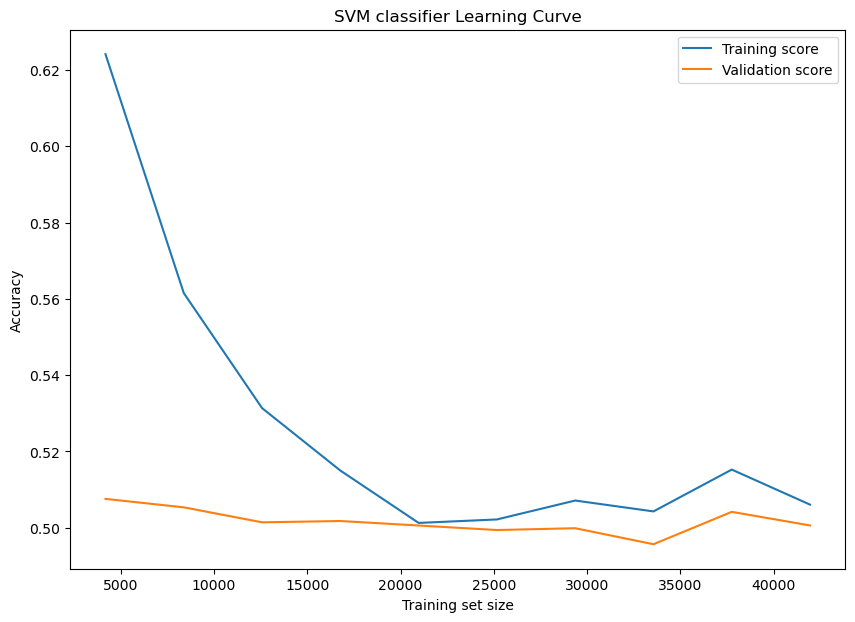

In [8]:
plt.figure(figsize=(10,7))
plt.plot(SVM_train_sizes, np.mean(SVM_train_scores, axis=1), label='Training score')
plt.plot(SVM_train_sizes, np.mean(SVM_valid_scores, axis=1), label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('SVM classifier Learning Curve')
plt.legend()
plt.show()



In [10]:
svm_model = svm.LinearSVC()
svm_model.fit(train_dataset_image_Scaled, train_dataset_label)

y_test_hat = svm_model.predict(test_dataset_image_Scaled)
accuracy_svm_test = accuracy_score(test_dataset_label, y_test_hat)
print(f'Baseline model accuracy: {round(accuracy_svm_test * 100, 1)}% accuracy.')

Baseline model accuracy: 51.2% accuracy.


In [ ]:
#Boosting model

catboost = CatBoostClassifier(iterations=200, loss_function='CrossEntropy', eval_metric='Accuracy', 
                              random_seed=42,data_partition='FeatureParallel',early_stopping_rounds=20)
grid = {'learning_rate': [0.03,0.01,0.1, 0.2,0.4],
        'depth': [1,2,4,6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = catboost.randomized_search(grid,
                                                   X=train_dataset_image_Scaled,
                                                   y=train_dataset_label,
                                                   plot=True)

# # task_type="GPU"

In [ ]:
randomized_search_result 

{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.1}

#Grayscale fit
'params': {'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.2},

{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.1}

In [5]:
#Kør denne model

catboost = CatBoostClassifier(iterations=500, learning_rate=0.2, depth=6,l2_leaf_reg=7, loss_function='CrossEntropy', eval_metric='Accuracy', random_seed=42,data_partition='FeatureParallel' )
fitted_catboost = catboost.fit(train_dataset_image_Scaled, train_dataset_label,eval_set=(validation_dataset_image_Scaled, validation_dataset_label), use_best_model=True)



0:	learn: 0.6532644	test: 0.6361416	best: 0.6361416 (0)	total: 260ms	remaining: 2m 9s
1:	learn: 0.6842396	test: 0.6923077	best: 0.6923077 (1)	total: 373ms	remaining: 1m 32s
2:	learn: 0.6994411	test: 0.7148962	best: 0.7148962 (2)	total: 496ms	remaining: 1m 22s
3:	learn: 0.7101223	test: 0.7087912	best: 0.7148962 (2)	total: 608ms	remaining: 1m 15s
4:	learn: 0.7185336	test: 0.7228327	best: 0.7228327 (4)	total: 759ms	remaining: 1m 15s
5:	learn: 0.7260295	test: 0.7271062	best: 0.7271062 (5)	total: 864ms	remaining: 1m 11s
6:	learn: 0.7322665	test: 0.7252747	best: 0.7271062 (5)	total: 969ms	remaining: 1m 8s
7:	learn: 0.7358714	test: 0.7313797	best: 0.7313797 (7)	total: 1.07s	remaining: 1m 6s
8:	learn: 0.7394000	test: 0.7356532	best: 0.7356532 (8)	total: 1.18s	remaining: 1m 4s
9:	learn: 0.7427569	test: 0.7448107	best: 0.7448107 (9)	total: 1.29s	remaining: 1m 3s
10:	learn: 0.7456179	test: 0.7460317	best: 0.7460317 (10)	total: 1.4s	remaining: 1m 2s
11:	learn: 0.7478113	test: 0.7503053	best: 0.750

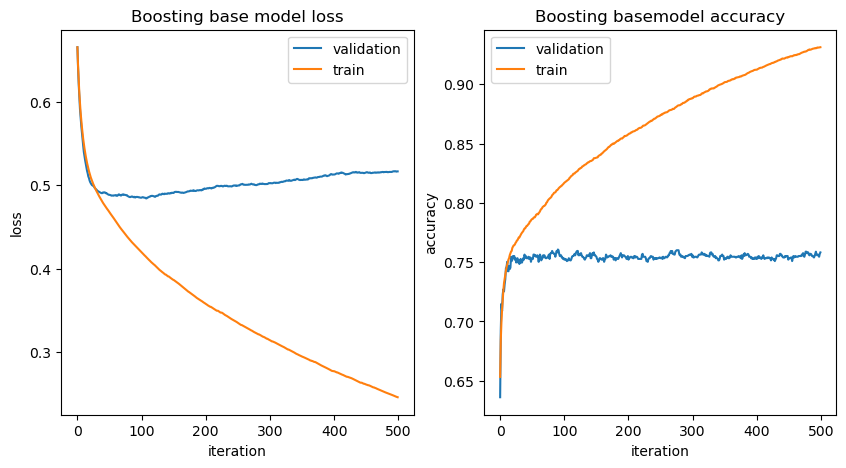

In [8]:


#from tsv file to dataframe

df_test = pd.read_csv(file_dir + r'\catboost_info\test_error.tsv', sep='\t')
df_train = pd.read_csv(file_dir + r'\catboost_info\learn_error.tsv', sep='\t')
#plot accuracy and loss from dataframe 


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(df_test['CrossEntropy'])
plt.plot(df_train['CrossEntropy'])
plt.title('Boosting base model loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['validation', 'train'], loc='upper right')


plt.subplot(1,2,2)
plt.plot(df_test['Accuracy'])
plt.plot(df_train['Accuracy'])
plt.title('Boosting basemodel accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['validation', 'train'], loc='upper left')
plt.show()


In [7]:
#Catboost prediction on grayscale images 32x32
y_test_hat = fitted_catboost.predict(test_dataset_image_Scaled)
accuracy = accuracy_score(test_dataset_label, y_test_hat)
print(f'Baseline model accuracy: {round(accuracy * 100, 1)}% accuracy.')

#Baseline model accuracy: 74.7% accuracy.
#Vi vælger catboost modelen grundet bedre accuracy på test set
#Baseline er catboost med 32x32 grayscale images


Baseline model accuracy: 74.7% accuracy.
